We're going to build an RNN that does predicts the next token, based on context tokens; which can be used to generate text from input string. This model is outlined in Chapter 3 of **The Hundred Page Language Models Book**.

In [23]:
from datetime import datetime, timedelta
import math 
import os
import random 
import re 
import tarfile
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, IterableDataset
from tqdm import tqdm
from transformers import AutoTokenizer # pretrained tokenizer from Hugging Face Hub
import urllib.request

## Utilities

Helper methods:

In [32]:
#
# source: https://github.com/aburkov/theLMbook/blob/main/news_RNN_language_model.ipynb
#
def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


#
# source: https://github.com/aburkov/theLMbook/blob/main/news_RNN_language_model.ipynb
#
def check_file_exists(filename):
    """
    Checks if a file exists in the current directory.
    Args:
        filename (str): Name of the file to check
    Returns:
        bool: True if file exists, False otherwise
    """
    return os.path.exists(filename)


#
# source: https://github.com/aburkov/theLMbook/blob/main/news_RNN_language_model.ipynb
#
def create_collate_fn(tokenizer):
    """
    Creates a collate function for batching sequences of different lengths.
    This function pads shorter sequences to match the longest sequence in the batch.

    Args:
        tokenizer: Tokenizer object containing padding token information

    Returns:
        function: Collate function that handles padding in batches
    """
    def collate_fn(batch):
        # Separate inputs and targets from batch
        input_seqs, target_seqs = zip(*batch)
        # Get padding token ID from tokenizer
        pad_index = tokenizer.pad_token_id
        # Pad input sequences to same length
        input_padded = nn.utils.rnn.pad_sequence(input_seqs, batch_first=True, padding_value=pad_index)
        # Pad target sequences to same length
        target_padded = nn.utils.rnn.pad_sequence(target_seqs, batch_first=True, padding_value=pad_index)
        return input_padded, target_padded
    return collate_fn

#
# source: https://github.com/aburkov/theLMbook/blob/main/news_RNN_language_model.ipynb
#
def download_and_prepare_data(url, batch_size, tokenizer, max_length=30):
    """
    Main function to handle the complete data preparation pipeline.
    Downloads data, extracts it, and creates necessary dataset objects.

    Args:
        url (str): URL where the dataset archive can be downloaded
        batch_size (int): Batch size for data loading
        tokenizer: Tokenizer object for text processing
        max_length (int): Maximum sequence length for tokenization (default: 30)

    Returns:
        tuple: (train_dataloader, test_dataloader) - Ready-to-use data loaders
    """
    # Step 1: Download dataset archive from URL
    filename = download_file(url)

    # Step 2: Extract training and test files from archive
    train_file, test_file = extract_dataset(filename)

    # Step 3: Create dataset objects for streaming data
    train_dataset, test_dataset = create_datasets(train_file, test_file, tokenizer, max_length)

    # Step 4: Create function to handle batch creation
    collate_fn = create_collate_fn(tokenizer)

    # Step 5: Create and return data loaders
    return create_dataloaders(train_dataset, test_dataset, batch_size, collate_fn)


#
# source: https://github.com/aburkov/theLMbook/blob/main/news_RNN_language_model.ipynb
#
def download_file(url):
    """
    Downloads a file from the given URL if it doesn't exist locally.
    Uses a custom User-Agent to help prevent download blocks.

    Args:
        url (str): URL of the file to download
    Returns:
        str: Name of the downloaded file ("news.tar.gz")
    """
    # Always use news.tar.gz as the filename, regardless of URL
    filename = "news.tar.gz"

    if not check_file_exists(filename):
        print(f"Downloading dataset from {url}...")
        req = urllib.request.Request(
            url,
            headers={"User-Agent": "Mozilla/5.0"}
        )
        with urllib.request.urlopen(req) as response:
            with open(filename, "wb") as out_file:
                out_file.write(response.read())
        print("Download completed.")
    else:
        print(f"{filename} already downloaded.")
    return filename


#
# source: https://github.com/aburkov/theLMbook/blob/main/news_RNN_language_model.ipynb
#
def extract_dataset(filename):
    """
    Extracts train.txt and test.txt from the downloaded archive.
    Includes debug information about archive contents.

    Args:
        filename (str): Name of the archive file
    Returns:
        tuple: Paths to extracted train and test files
    """
    data_dir = os.path.join(os.path.dirname(filename), "news")
    train_path = os.path.join(data_dir, "train.txt")
    test_path = os.path.join(data_dir, "test.txt")

    if check_file_exists(train_path) and check_file_exists(test_path):
        print("Data files already extracted.")
        return train_path, test_path

    print("\nListing archive contents:")
    with tarfile.open(filename, "r:gz") as tar:
        for member in tar.getmembers():
            print(f"Archive member: {member.name}")

        print("\nExtracting files...")
        # Extract to current directory first
        tar.extractall('.')

    if not (check_file_exists(train_path) and check_file_exists(test_path)):
        raise FileNotFoundError(f"Required files not found in the archive. Please check the paths above.")

    print("Extraction completed.")
    return train_path, test_path

    
#
# source: https://github.com/aburkov/theLMbook/blob/main/news_RNN_language_model.ipynb
#
def create_datasets(train_file, test_file, tokenizer, max_length=30):
    """
    Creates IterableTextDataset objects for training and testing.
    These datasets will stream data from disk instead of loading it all into memory.

    Args:
        train_file (str): Path to training data file
        test_file (str): Path to test data file
        tokenizer: Tokenizer object for text processing

    Returns:
        tuple: (train_dataset, test_dataset) - Dataset objects for training and testing
    """
    # Create training dataset
    train_dataset = IterableTextDataset(train_file, tokenizer, max_length)
    # Create test dataset
    test_dataset = IterableTextDataset(test_file, tokenizer, max_length)

    # Print dataset sizes
    print(f"Training sentences: {len(train_dataset)}")
    print(f"Test sentences: {len(test_dataset)}")

    return train_dataset, test_dataset

    
#
# source: https://github.com/aburkov/theLMbook/blob/main/news_RNN_language_model.ipynb
#
def create_dataloaders(train_dataset, test_dataset, batch_size, collate_fn):
    """
    Creates DataLoader objects for efficient data iteration.

    Args:
        train_dataset: Training dataset
        test_dataset: Test dataset
        batch_size (int): Number of sequences per batch
        collate_fn: Function to handle padding and batch creation

    Returns:
        tuple: (train_dataloader, test_dataloader) - DataLoader objects for
               iterating over batches of data with proper padding
    """
    # Create training data loader
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,    # Function to handle padding
        num_workers=0             # Number of worker processes (0 = single process)
    )
    # Create test data loader
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        num_workers=0
    )
    return train_dataloader, test_dataloader


#
# source: https://github.com/aburkov/theLMbook/blob/main/news_RNN_language_model.ipynb
#
class IterableTextDataset(IterableDataset):
    """
    An iterable dataset for processing text data in a memory-efficient way.
    Instead of loading all data into memory, it streams data from disk.
    Inherits from PyTorch's IterableDataset for streaming support.

    Args:
        file_path (str): Path to the text file containing sentences
        tokenizer: Tokenizer object for converting text to tokens
        max_length (int): Maximum sequence length to process (default: 30)
    """
    def __init__(self, file_path, tokenizer, max_length=30):
        # Store file path for reading data
        self.file_path = file_path
        # Store tokenizer for text processing
        self.tokenizer = tokenizer
        # Set maximum sequence length to truncate long sequences
        self.max_length = max_length
        self._count_sentences()

    def __iter__(self):
        """
        Creates an iterator over the dataset.
        This method is called when iterating over the dataset.

        Yields:
            tuple: (input_sequence, target_sequence) pairs for language modeling
                  input_sequence is the sequence up to the last token
                  target_sequence is the sequence shifted one position right
        """
        # Open file in read mode with UTF-8 encoding
        with open(self.file_path, 'r', encoding="utf-8") as f:
            # Process each line (sentence) in the file
            for line in f:
                # Remove leading/trailing whitespace
                sentence = line.strip()
                # Replace all numbers with ### placeholder
                # This reduces vocabulary size and helps model generalize
                sentence = re.sub(r"\d+", "###", sentence)

                # Convert sentence to token IDs
                encoded_sentence = self.tokenizer.encode(
                    sentence,
                    max_length=self.max_length,
                    truncation=True
                )

                # Only use sequences with at least 2 tokens
                # (need at least one input and one target token)
                if len(encoded_sentence) >= 2:
                    # Input is all tokens except last
                    input_seq = encoded_sentence[:-1]
                    # Target is all tokens except first
                    target_seq = encoded_sentence[1:]
                    # Convert to PyTorch tensors and yield
                    yield torch.tensor(input_seq, dtype=torch.long), torch.tensor(target_seq, dtype=torch.long)
    def __len__(self):
        return self._num_sentences

    def _count_sentences(self):
        print(f"Counting sentences in {self.file_path}...")
        with open(self.file_path, 'r', encoding="utf-8") as f:
            self._num_sentences = sum(1 for _ in f)
        print(f"Found {self._num_sentences} sentences in {self.file_path}.")


#
# source: https://github.com/aburkov/theLMbook/blob/main/news_RNN_language_model.ipynb
#
def initialize_weights(model):
    """
    Initializes model weights using Xavier uniform initialization for multi-dimensional
    parameters and uniform initialization for biases and other 1D parameters.

    Args:
        model (nn.Module): PyTorch model whose weights need to be initialized
    """
    # Loop through all named parameters in the model
    for name, param in model.named_parameters():
        # Check if parameter has more than 1 dimension (e.g., weight matrices)
        if param.dim() > 1:
            # Use Xavier uniform initialization for weight matrices
            # This helps prevent vanishing/exploding gradients by keeping the variance constant
            nn.init.xavier_uniform_(param)
        else:
            # For 1D parameters (like biases), use simple uniform initialization
            nn.init.uniform_(param)


#
# source: https://github.com/aburkov/theLMbook/blob/main/news_RNN_language_model.ipynb
#
def compute_loss_and_perplexity(model, dataloader, tokenizer, criterion, device, max_sentences=1000):
    """
    Evaluates model performance by computing loss and perplexity on data.

    Args:
        model (nn.Module): The language model to evaluate
        dataloader (DataLoader): Data loader containing batched sequences
        tokenizer: Tokenizer for handling special tokens like padding
        criterion: Loss function (usually CrossEntropyLoss)
        device: Device to run computation on (cuda/cpu)
        max_sentences (int): Maximum number of sentences to evaluate (default: 1000)
                           Limits evaluation to a subset for faster validation

    Returns:
        tuple: (average_loss, perplexity)
               - average_loss: Mean loss per token (excluding padding)
               - perplexity: exp(average_loss), lower is better
    """
    # Set model to evaluation mode (disables dropout, etc.)
    model.eval()

    # Initialize counters for loss calculation
    total_loss = 0.0          # Accumulator for total loss across all batches
    total_tokens = 0          # Counter for total number of tokens (excluding padding)
    sentences_processed = 0    # Counter for number of sentences processed

    # Disable gradient computation for efficiency
    with torch.no_grad():
        # Iterate through data with progress bar
        for input_seq, target_seq in tqdm(dataloader, desc="Evaluating", leave=False):
            # Move input and target sequences to specified device
            input_seq = input_seq.to(device)      # Shape: (batch_size, seq_len)
            target_seq = target_seq.to(device)    # Shape: (batch_size, seq_len)

            # Get current batch size (might be smaller for last batch)
            batch_size_current = input_seq.size(0)

            # Forward pass through the model
            logits = model(input_seq)             # Shape: (batch_size, seq_len, vocab_size)

            # Reshape logits and target for loss calculation
            logits = logits.reshape(-1, logits.size(-1))  # Shape: (batch_size * seq_len, vocab_size)
            target = target_seq.reshape(-1)              # Shape: (batch_size * seq_len)

            # Create mask to exclude padding tokens
            mask = target != tokenizer.pad_token_id

            # Compute loss only on non-padded tokens
            loss = criterion(logits[mask], target[mask])

            # Update counters
            loss_value = loss.item() * mask.sum().item()  # Total loss for this batch
            total_loss += loss_value                      # Accumulate batch loss
            total_tokens += mask.sum().item()             # Count non-padding tokens

            # Update sentence counter and check if we've reached maximum
            sentences_processed += batch_size_current
            if sentences_processed >= max_sentences:
                break

    # Calculate final metrics
    average_loss = total_loss / total_tokens           # Normalize loss by number of tokens
    perplexity = math.exp(average_loss)               # Convert loss to perplexity

    return average_loss, perplexity


#
# source: https://github.com/aburkov/theLMbook/blob/main/news_RNN_language_model.ipynb
#
def perform_model_evaluation(model, test_dataloader, criterion, tokenizer, device, contexts):
    """
    Perform evaluation of the model including loss calculation, perplexity, and text generation.

    Args:
        model: The neural network model
        test_dataloader: DataLoader containing test/validation data
        criterion: Loss function
        tokenizer: Tokenizer for text generation
        device: Device to run computations on (cuda/cpu)
        contexts: List of context strings for text generation

    Returns:
        tuple: (average_loss, perplexity)
    """
    # Switch to evaluation mode
    model.eval()

    # Compute metrics
    average_loss, perplexity = compute_loss_and_perplexity(
        model, test_dataloader, tokenizer, criterion, device, max_sentences=1000
    )

    print(f"Validation Average Loss: {average_loss:.4f}, Perplexity: {perplexity:.2f}")

    # Generate text using the contexts
    print("Generating text based on contexts using generate_text:\n")
    for context in contexts:
        generated_text = generate_text(
            model=model,          # The loaded language model
            start_string=context, # Context to continue
            tokenizer=tokenizer,  # Tokenizer for text conversion
            device=device,        # CPU or GPU device
            max_length=50         # Maximum length of generated sequence
        )
        print(f"\nContext: {context}")
        print(f"\nGenerated text: {generated_text}\n")

    return average_loss, perplexity


#
# source: https://github.com/aburkov/theLMbook/blob/main/news_RNN_language_model.ipynb
#
def generate_text(model, start_string, tokenizer, device, max_length=50):
    """
    Generates text continuation from a given start string using greedy decoding.
    This method always chooses the most likely next token.

    Args:
        model (nn.Module): Trained language model
        start_string (str): Initial text to continue from
        tokenizer: Tokenizer for text processing
        device: Device to run generation on (cuda/cpu)
        max_length (int): Maximum length of generated sequence

    Returns:
        str: Generated text continuation
    """
    # Set model to evaluation mode
    model.eval()

    # Convert start string to token ids and move to device
    # return_tensors="pt" returns PyTorch tensor instead of list
    tokens = tokenizer.encode(start_string, return_tensors="pt", max_length=max_length, truncation=True).to(device)

    # Initialize generated sequence with input tokens
    generated = tokens

    # Generate new tokens one at a time
    for _ in range(max_length):
        # Get model's predictions
        output = model(generated)                    # Shape: (1, seq_len, vocab_size)
        # Get logits for the next token (last position)
        next_token_logits = output[0, -1, :]        # Shape: (vocab_size)

        # Choose token with highest probability (greedy decoding)
        # unsqueeze twice to match expected shape (1, 1)
        next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(0).unsqueeze(0)

        # Add new token to generated sequence
        generated = torch.cat((generated, next_token_id), dim=1)

        # Stop if end of sequence token is generated
        if next_token_id.item() == tokenizer.eos_token_id:
            break

    # Convert token ids back to text
    generated_text = tokenizer.decode(generated.squeeze().tolist())
    return generated_text

## Encodings

Before that, let's test out PyTorch embeddings module. This is basically a lookup table that generates random embeddings for words; i.e., it maps a vocabulary of size `num_embeddings` to a lower set of dimensions of size `embedding_dim`:

In [7]:
emb = nn.Embedding(num_embeddings=5, embedding_dim=3, padding_idx=0)

emb

Embedding(5, 3, padding_idx=0)

In [8]:
sample = torch.tensor([0, 2, 4])
emb(sample)

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 2.4208,  3.1508, -0.6206],
        [ 0.1543,  1.1907,  0.4148]], grad_fn=<EmbeddingBackward0>)

In [9]:
sample = torch.tensor([0,1,3])
emb(sample)

tensor([[ 0.0000,  0.0000,  0.0000],
        [-0.3132,  0.2013, -0.4634],
        [ 1.6002, -0.7654, -0.1727]], grad_fn=<EmbeddingBackward0>)

## Define the RNN

Here's the architecture:

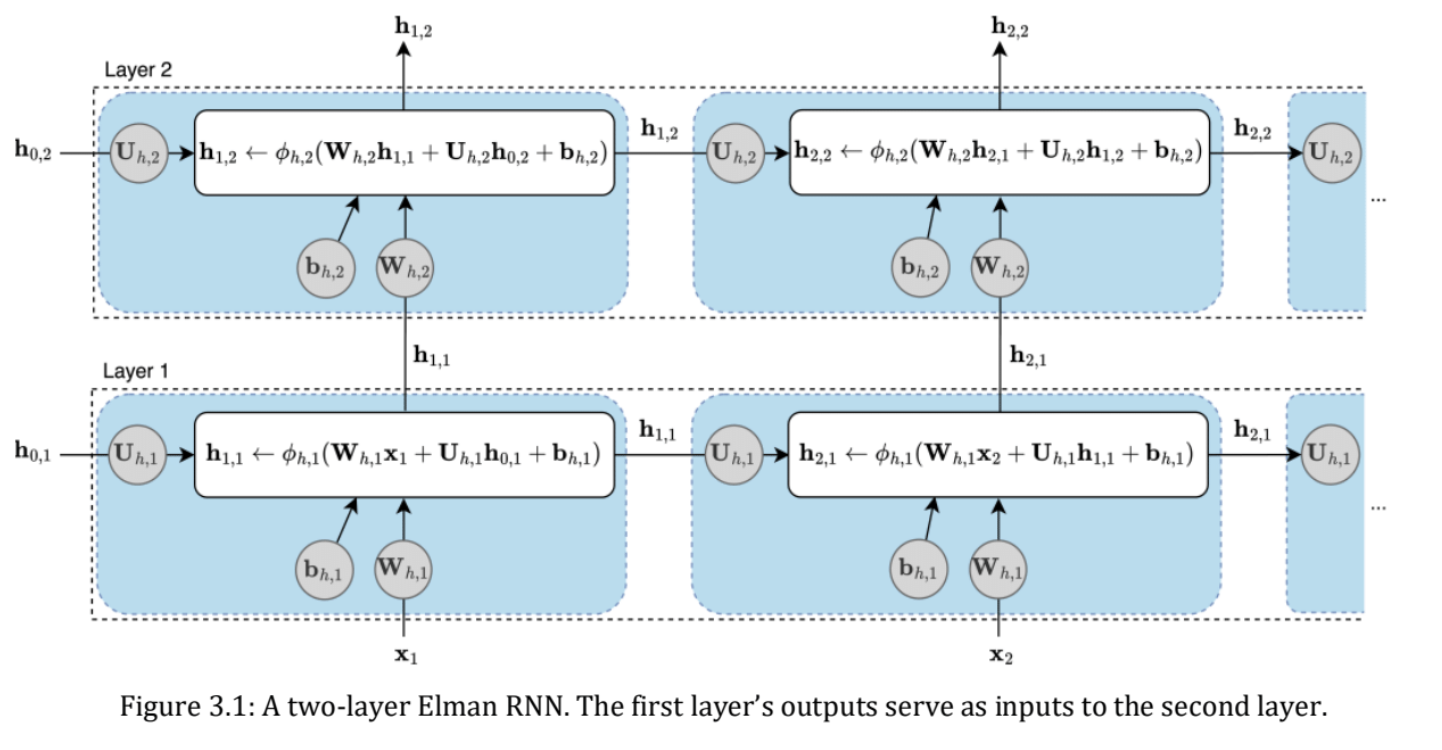

Note that at training time, we define the number of vertical layers (which make up the Elman RNN) - but at inference time, its the **sequence length** that defines the "width" of this neural network above. I.e., the one Elman RNN of n layers is recurrent, and each token will result in another pass through the network and produce another value of `h`.

Steps:
1. First, we'll define an **Elman RNN Unit**, which represents a single node (single blue box above)
2. Then, we'll define an **Elman RNN**, which is made up n layers of RNN units
3. Then, we'll define the RNN language model, which include the Elman RNN as well as embedding and linear output layers

After this section, we'll train and evaluate the model.

### Elman RNN unit

In [10]:
class ElmanRNNUnit(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        # U learned parameters 
        self.Uh = nn.Parameter(torch.randn(emb_dim, emb_dim))
        # W learned parameters
        self.Wh = nn.Parameter(torch.randn(emb_dim, emb_dim))
        self.b = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x, h):
        #
        # tanh activation fn, range [-1,1], often used for hidden layers in language models
        # 
        #     Computes Wx + Yh + b
        #
        return torch.tanh(x @ self.Wh + h @ self.Uh + self.b)

### Elman RNN

In [11]:
class ElmanRNN(nn.Module):
    def __init__(self, emb_dim, num_layers):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_layers = num_layers
        self.rnn_units = nn.ModuleList(
            [ElmanRNNUnit(emb_dim) for _ in range(num_layers)]
        )

    def forward(self, x):
        batch_size, seq_len, emb_dim = x.shape
        #
        # initial h for first token is 0s, subsequent will be outputs from prev token.
        #    (hence, recurrant)
        # 
        h_prev = [ # forward any device (e.g., cpu, gpu, tpu) settings
            torch.zeros(batch_size, emb_dim, device=x.device) for _ in range(self.num_layers)
        ]
        outputs = []
        # for each token in sequence...
        for t in range(seq_len):
            input_t = x[:, t]
            #print(f'DEBUG: input_t = {input_t}')
            # pass the token through each layer (RNN unit)...
            for l, rnn_unit in enumerate(self.rnn_units):
                # TODO: update hidden state of h???
                h_prev[l] = rnn_unit(input_t, h_prev[1])
                # input for next layer
                input_t = h_prev[l]
            outputs.append(input_t)
        return torch.stack(outputs, dim=1)
        

### RNN language model

In [12]:
class RecurrentLanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_dim, num_layers, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size,
            emb_dim,
            padding_idx=pad_idx
        )
        self.rnn = ElmanRNN(emb_dim, num_layers)
        self.fc = nn.Linear(emb_dim, vocab_size)

    def forward(self,x):
        embeddings = self.embedding(x)
        rnn_output = self.rnn(embeddings)
        logits = self.fc(rnn_output)
        return logits

## Train

In [14]:
# we'll use the Phi 3.5 mini tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")
vocab_size = len(tokenizer)
vocab_size

32011

In [45]:
# Test out the tokenizer
tokens = tokenizer.encode(
    "In addition to sending aid to the struggling economy unfamiliarly",
    max_length=50,
    truncation=True
)

print(f'tokens = {tokens}')

for token in tokens:
    print(f'token={token} value={tokenizer.decode([token])}')

tokens = [512, 6124, 304, 9348, 16226, 304, 278, 20042, 26504, 443, 8302, 4447, 368]
token=512 value=In
token=6124 value=addition
token=304 value=to
token=9348 value=sending
token=16226 value=aid
token=304 value=to
token=278 value=the
token=20042 value=struggling
token=26504 value=economy
token=443 value=un
token=8302 value=famil
token=4447 value=iar
token=368 value=ly


In [15]:
# Hyperparameters
emb_dim = 128
num_layers = 2
batch_size = 128
learning_rate = 0.001
num_epochs = 1 
context_size = 30

In [18]:
# fetch and prepare training and validation data
data_url = "https://www.thelmbook.com/data/news"
train_loader, test_loader = download_and_prepare_data(
    data_url, batch_size, tokenizer
)

print(f'Total of {len(train_loader)} batches in training dataset.')

news.tar.gz already downloaded.
Data files already extracted.
Counting sentences in news/train.txt...
Found 22034911 sentences in news/train.txt.
Counting sentences in news/test.txt...
Found 449693 sentences in news/test.txt.
Training sentences: 22034911
Test sentences: 449693
Total of 172148 batches in training dataset.


Find a usable device, and default to CPU. On my MacBook Air M2:
* If using CPU, training takes (10.68*100/.58)/60 = ~30.7hr
* If using GPU (via MPS), training takes (10.68*100/.58)/60 = ~13.1hr

In [46]:
def get_device_label():
    if torch.backends.mps.is_available():
        return "mps"
    elif torch.cuda.is_available():
        return "cuda"
    else:
        return "cpu"


device = torch.device(get_device_label())
print(f'Using device: {device}')

# verify
x = torch.ones(1, device=device)
print(x)

Using device: mps
tensor([1.], device='mps:0')


In [31]:
%%time

# training starts here
model = RecurrentLanguageModel(
    vocab_size, emb_dim, num_layers, tokenizer.pad_token_id
)

initialize_weights(model)

model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

start = datetime.now()

for epoch in range(num_epochs):
    model.train()
    for idx, batch in enumerate(train_loader):
        if idx % 1000 == 0:
            ellapsed = datetime.now() - start
            print(f'[epoch={epoch}] batch {idx} of {len(train_loader)} - {100*idx/len(train_loader):.2f}% done - {timedelta(seconds=ellapsed.total_seconds())} ellapsed')
        
        # prep X and y values 
        input_seq, target_seq = batch
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)
        batch_size_current, seq_len = input_seq.shape

        # forward pass
        optimizer.zero_grad()
        output = model(input_seq)
        #print(f'DEBUG: epoch={epoch} input_seq={input_seq} target_seq={target_seq} output={output}')
        
        # backpropogate error
        output = output.reshape(batch_size_current * seq_len, vocab_size)b
        target = target_seq.reshape(batch_size_current * seq_len)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

[epoch=0] batch 0 of 172148 - 0.00% done - 0:00:00.013207 ellapsed
[epoch=0] batch 1000 of 172148 - 0.58% done - 0:04:33.519919 ellapsed
[epoch=0] batch 2000 of 172148 - 1.16% done - 0:09:08.341836 ellapsed
[epoch=0] batch 3000 of 172148 - 1.74% done - 0:13:41.794978 ellapsed
[epoch=0] batch 4000 of 172148 - 2.32% done - 0:18:16.350441 ellapsed
[epoch=0] batch 5000 of 172148 - 2.90% done - 0:22:57.113256 ellapsed
[epoch=0] batch 6000 of 172148 - 3.49% done - 0:27:35.927723 ellapsed
[epoch=0] batch 7000 of 172148 - 4.07% done - 0:32:15.612264 ellapsed
[epoch=0] batch 8000 of 172148 - 4.65% done - 0:36:50.383588 ellapsed
[epoch=0] batch 9000 of 172148 - 5.23% done - 0:41:25.351493 ellapsed
[epoch=0] batch 10000 of 172148 - 5.81% done - 1:01:50.740197 ellapsed
[epoch=0] batch 11000 of 172148 - 6.39% done - 1:22:25.857147 ellapsed
[epoch=0] batch 12000 of 172148 - 6.97% done - 1:52:30.279065 ellapsed
[epoch=0] batch 13000 of 172148 - 7.55% done - 1:59:38.123273 ellapsed
[epoch=0] batch 140

In [34]:
# Save the model
model_file = "./rnn.pth"
torch.save(model.state_dict(), model_file)

In [39]:
# validate that we can load the model
model2 = RecurrentLanguageModel( 
    vocab_size, emb_dim, num_layers, tokenizer.pad_token_id
)
model2.load_state_dict(torch.load(model_file, weights_only=True))
model2.eval()
model2.to(device)

generate_text(
    model=model2,
    start_string="In addition to sending aid to the struggling country, the president offered to",
    tokenizer=tokenizer,
    device=device,
    max_length=50
)

"In addition to sending aid to the struggling country, the president offered to be a `` very strongest '' . ' '' he said . ' '' he said . ' '' he said . ' '' he said . ' '' he said . ' '' he said . ' '' he said . ' '' he said . ' ''"

## Test

In [33]:
%%time

contexts = [
    "Moscow",
    "New York",
    "The hurricane",
    "The President"
]
perform_model_evaluation(model, test_loader, criterion, tokenizer, device, contexts)

Evaluating:   0%|                                                | 0/3514 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation Average Loss: 4.3766, Perplexity: 79.56
Generating text based on contexts using generate_text:


Context: Moscow

Generated text: Moscow , the former president , said he was not a member of the public . ' '' he said . ' '' he said . ' '' he said . ' '' he said . ' '' he said . ' '' he said . ' '' he said .


Context: New York

Generated text: New York City 's first-half strike was a ##-year-old boy , who was a member of the ##-year-old , who was a member of the ##-year-old , who was a member of the ##-year-


Context: The hurricane

Generated text: The hurricane , the ##-year-old was arrested on suspicion of murdering the police officer . ' '' he said . ' '' he said . ' '' he said . ' '' he said . ' '' he said . ' '' he said . '


Context: The President

Generated text: The President of the ####s of the ####s , which is also the same . ' '' the statement said . 's the . ' '' The FBI said the investigation was `` a matter of '' . '' 's . ' '' he said . '

CPU times: user 2.18

(4.376552756065364, 79.56328606131252)